# Experiment: Varying N in top-N DDA fragmentation

We demonstrate that the simulator can be used for scan-level closed-loop DDA experiments. 
- Take an existing data. Find out which MS1 peaks are linked to which MS2 peaks.
- Run all MS1 peaks through the simulator’s Top-N protocol. 
- For the top-100 most intense MS1 peaks, how many got fragmented in the simulator as we change N?
- If N is greater than the real data, do we see the same MS1 peaks from (1) being fragmented again, plus additional fragment peaks?
- Verification on actual machine.
- Talk to stefan about machine time.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import os
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt
from random import random, shuffle
from joblib import Parallel, delayed
import multiprocessing

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

In [6]:
set_log_level_debug()

### Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [7]:
ps = load_obj('../models/peak_sampler_4_beers.p')

### Load chromatogram data exported from the real data (BEER1POS)

Correct the positively charged ions by substracting the mass of a proton

In [8]:
def f(peak_mz, chrom_mzs):
    peak_mz = peak_mz - PROTON_MASS
    chrom_mzs = chrom_mzs - PROTON_MASS
    return peak_mz, chrom_mzs

In [9]:
xcms_output = '../models/beer1pos_ms1_peaks.csv.gz'
cc = ChromatogramCreator(xcms_output, correction_func=f)

DEBUG:ChromatogramCreator:Loading 0 chromatograms
DEBUG:ChromatogramCreator:Invalid chromatogram 307
DEBUG:ChromatogramCreator:Invalid chromatogram 449
DEBUG:ChromatogramCreator:Invalid chromatogram 1505
DEBUG:ChromatogramCreator:Invalid chromatogram 1558
DEBUG:ChromatogramCreator:Invalid chromatogram 2208
DEBUG:ChromatogramCreator:Invalid chromatogram 2828
DEBUG:ChromatogramCreator:Invalid chromatogram 3558
DEBUG:ChromatogramCreator:Invalid chromatogram 4140
DEBUG:ChromatogramCreator:Invalid chromatogram 4498
DEBUG:ChromatogramCreator:Invalid chromatogram 4969
DEBUG:ChromatogramCreator:Loading 5000 chromatograms
DEBUG:ChromatogramCreator:Invalid chromatogram 5233
DEBUG:ChromatogramCreator:Invalid chromatogram 5501
DEBUG:ChromatogramCreator:Invalid chromatogram 5754
DEBUG:ChromatogramCreator:Invalid chromatogram 5995
DEBUG:ChromatogramCreator:Invalid chromatogram 6449
DEBUG:ChromatogramCreator:Invalid chromatogram 7096
DEBUG:ChromatogramCreator:Invalid chromatogram 8724
DEBUG:Chromatog

#### Turn the loaded data into `UnknownChemical` objects.

In [10]:
min_ms1_intensity = 0
min_rt = 3*60
max_rt = 21*60
chemicals = ChemicalCreator(ps)
dataset = chemicals.sample_from_chromatograms(cc, min_rt, max_rt, min_ms1_intensity, ms_levels=2)

DEBUG:ChemicalCreator:11302 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 2500
DEBUG:ChemicalCreator:i = 5000
DEBUG:ChemicalCreator:i = 7500


In [11]:
len(dataset)

9653

### Add noise

#### Create region of interest objects

In [12]:
mzml_path = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\Positive\\samples\\mzML'
xcms_roi_file = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\Data\\Beers_4Beers_compared\\rois.csv'
extracted_roi_file = '../models/all_rois.p'

In [13]:
ds = DataSource()
ds.load_data(mzml_path)
try:
    ds.load_roi(extracted_roi_file)
except FileNotFoundError:
    print('Extracting ROIs')
    ds.extract_roi(xcms_roi_file, min_rt=min_rt, max_rt=max_rt)
    ds.populate_roi()
    ds.save_roi(extracted_roi_file)

INFO:DataSource:Loading Beer_1_full1.mzML
INFO:DataSource:Loading Beer_1_full2.mzML
INFO:DataSource:Loading Beer_1_full3.mzML
INFO:DataSource:Loading Beer_2_full1.mzML
INFO:DataSource:Loading Beer_2_full2.mzML
INFO:DataSource:Loading Beer_2_full3.mzML
INFO:DataSource:Loading Beer_3_full1.mzML
INFO:DataSource:Loading Beer_3_full2.mzML
INFO:DataSource:Loading Beer_3_full3.mzML
INFO:DataSource:Loading Beer_QC_full1.mzML
INFO:DataSource:Loading Beer_QC_full2.mzML
INFO:DataSource:Loading Beer_QC_full3.mzML


In [14]:
filename = list(ds.all_rois.keys())[0]

In [15]:
filename

'Beer_1_full1.mzML'

#### Add a whole bunch of `UnknownChemicals` with chromatograms coming from non-peak ROIs from Beer1Pos

In [16]:
min_ms1_intensity = 2E5

In [17]:
rtcc = RoiToChemicalCreator(ps, ds, filename,  min_ms1_intensity=min_ms1_intensity)

DEBUG:RoiToChemicalCreator:     0/227772
../codes\VMSfunctions\Common.py:58: RuntimeWarning:

divide by zero encountered in double_scalars

DEBUG:RoiToChemicalCreator: 50000/227772
DEBUG:RoiToChemicalCreator:100000/227772
DEBUG:RoiToChemicalCreator:150000/227772
DEBUG:RoiToChemicalCreator:200000/227772
INFO:RoiToChemicalCreator:Found 12914 ROIs above thresholds


In [18]:
len(rtcc.chemicals)

12914

In [19]:
def plot_chems(chem_list, N=10):
    for c in chem_list[0:N]:
        chrom = c.chromatogram
        plt.plot(chrom.raw_rts, chrom.raw_intensities)
        plt.show()

In [20]:
sorted_chems = sorted(rtcc.chemicals, key = lambda chem: chem.chromatogram.roi.num_scans())

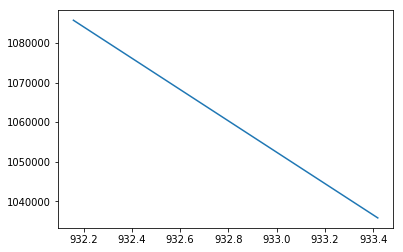

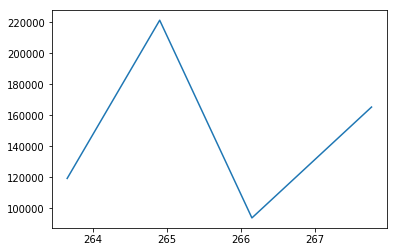

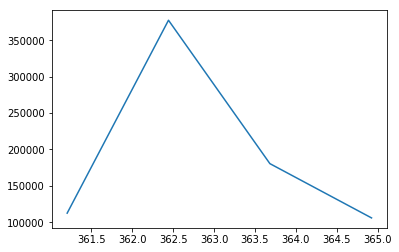

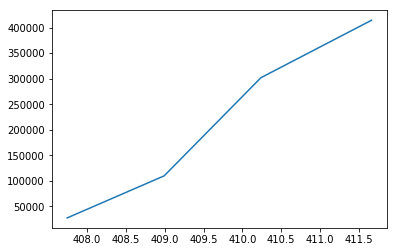

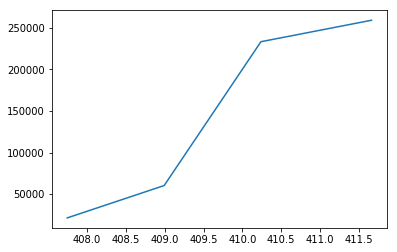

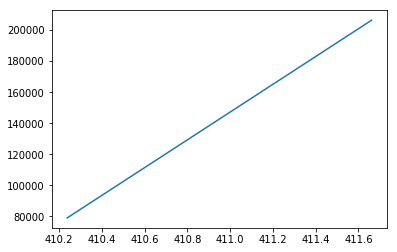

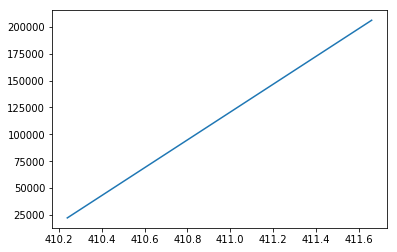

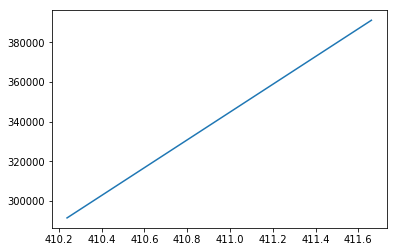

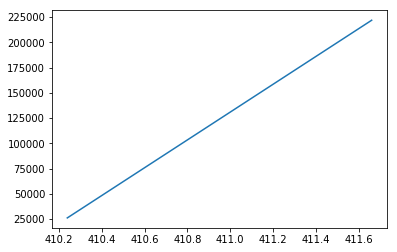

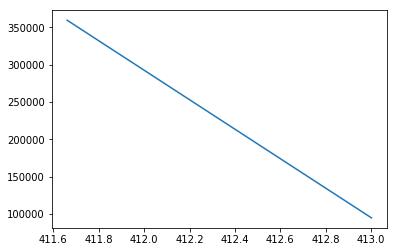

In [21]:
plot_chems(sorted_chems[0:10])

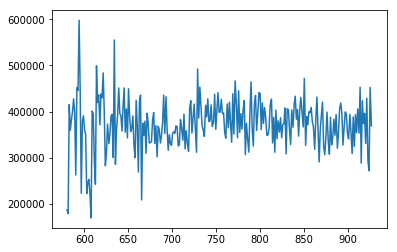

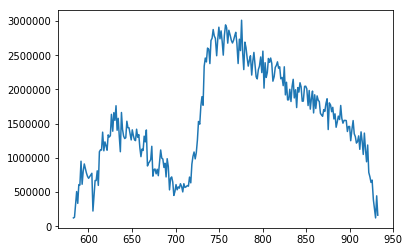

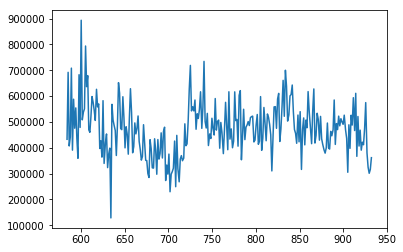

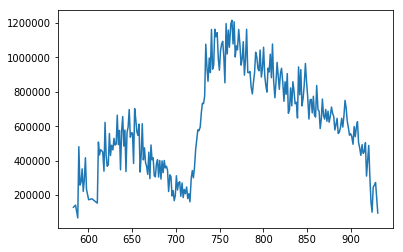

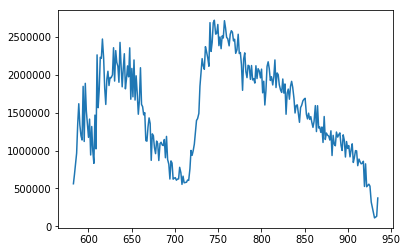

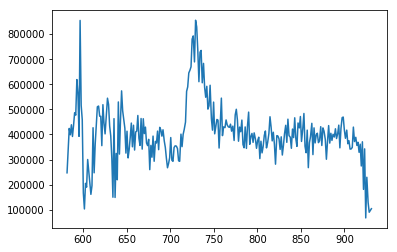

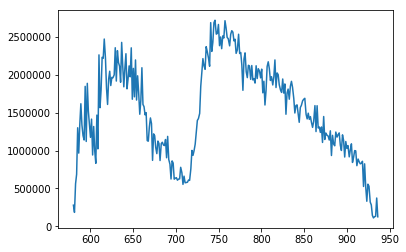

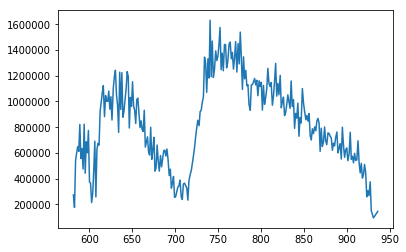

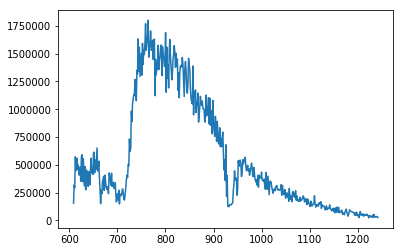

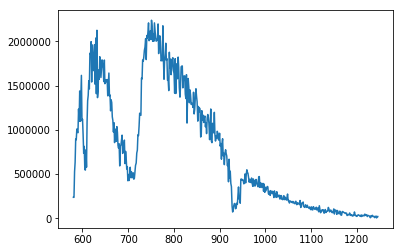

In [22]:
plot_chems(sorted_chems[-10:])

#### Add non-peaks regions of interest to the data

In [23]:
for chem in dataset:
    chem.type = 'data'
for noise in sorted_chems:
    noise.type = 'noise'

In [24]:
noisy_dataset = dataset + sorted_chems

In [25]:
shuffle(noisy_dataset)

In [26]:
len(dataset)

9653

In [27]:
len(noisy_dataset)

22567

In [38]:
save_obj(dataset, '../models/dda_results/dataset.p')

In [39]:
save_obj(noisy_dataset, '../models/dda_results/noisy_dataset.p')

### Experiment by varying N and rt_tol

Don't print so much from the controller when running

In [28]:
set_log_level_warning()
# set_log_level_info()
# set_log_level_debug()

#### Set parameters

Varying parameters

In [29]:
Ns = range(1, 21, 1) # top-N DDA fragmentation
rt_tols = range(5, 31, 5) # the rt window around a selected precursor ion to prevent it from fragmented multiple times

Fixed parameters

In [30]:
isolation_window = 0.5   # the isolation window in Dalton around a selected precursor ion
ionisation_mode = POSITIVE
data = noisy_dataset
density = ps.density_estimator
min_ms1_intensity = 2E5 # minimum ms1 intensity to fragment

In [31]:
params = []
for N in Ns:
    for rt_tol in rt_tols:
        params.append({
            'N': N, 
            'rt_tol': rt_tol,
            'min_ms1_intensity': min_ms1_intensity,
            'isolation_window': isolation_window,
            'ionisation_mode': ionisation_mode,
            'data': data,
            'density': density,
            'min_rt': min_rt,
            'max_rt': max_rt
        })

In [32]:
len(params)

120

In [34]:
params.reverse()

#### Run serially

In [36]:
def run_serial_experiment(param, i, total):
    analysis_name = 'experiment_N_%d_rttol_%d' % (param['N'], param['rt_tol'])    
    mzml_out = '../models/dda_results/%s.mzML' % analysis_name    
    pickle_out = '../models/dda_results/%s.p' % analysis_name

    if os.path.isfile(mzml_out) and os.path.isfile(pickle_out): 
        print('Skipping\t%d/%d\t%s' % (i, total, analysis_name))
    else:    
        print('Processing\t%d/%d\t%s' % (i, total, analysis_name))
        mass_spec = IndependentMassSpectrometer(param['ionisation_mode'], param['data'], density=param['density'])
        controller = TopNController(mass_spec, param['N'], param['isolation_window'], param['rt_tol'], 
                                    param['min_ms1_intensity'])
        controller.run(param['min_rt'], param['max_rt'], progress_bar=True)
        controller.write_mzML(analysis_name, mzml_out)    
        save_obj(controller, pickle_out)

In [ ]:
for i in range(len(params)):
    param = params[i]
    run_serial_experiment(param, i+1, len(params))

Skipping	1/120	experiment_N_20_rttol_30
Skipping	2/120	experiment_N_20_rttol_25
Skipping	3/120	experiment_N_20_rttol_20
Skipping	4/120	experiment_N_20_rttol_15
Skipping	5/120	experiment_N_20_rttol_10
Skipping	6/120	experiment_N_20_rttol_5
Skipping	7/120	experiment_N_19_rttol_30
Skipping	8/120	experiment_N_19_rttol_25
Processing	9/120	experiment_N_19_rttol_20


1080.055338685175it [08:13,  2.19it/s]                                                                                                                                                                  


Processing	10/120	experiment_N_19_rttol_15


1080.039710363385it [08:11,  2.20it/s]                                                                                                                                                                  


Processing	11/120	experiment_N_19_rttol_10


1080.062594991374it [08:03,  2.23it/s]                                                                                                                                                                  


Processing	12/120	experiment_N_19_rttol_5


1080.0874178454553it [1:44:47,  5.82s/it]                                                                                                                                                               


Processing	13/120	experiment_N_18_rttol_30


1080.1037076954337it [08:32,  2.11it/s]                                                                                                                                                                 


Processing	14/120	experiment_N_18_rttol_25


1080.061461897712it [08:32,  2.11it/s]                                                                                                                                                                  


Processing	15/120	experiment_N_18_rttol_20


1080.014591530776it [08:26,  2.13it/s]                                                                                                                                                                  


Processing	16/120	experiment_N_18_rttol_15


1080.011465692174it [08:22,  2.84it/s]                                                                                                                                                                  


Processing	17/120	experiment_N_18_rttol_10


1080.058408025042it [07:54,  2.81it/s]                                                                                                                                                                  


Processing	18/120	experiment_N_18_rttol_5


1080.023541374683it [07:23,  2.44it/s]                                                                                                                                                                  


Processing	19/120	experiment_N_17_rttol_30


1080.0477569840796it [09:06,  2.68it/s]                                                                                                                                                                 


Processing	20/120	experiment_N_17_rttol_25


1080.0342834948174it [08:38,  2.08it/s]                                                                                                                                                                 


Processing	21/120	experiment_N_17_rttol_20


1080.059605186449it [09:04,  2.70it/s]                                                                                                                                                                  


Processing	22/120	experiment_N_17_rttol_15


1080.0003206289418it [08:22,  2.15it/s]                                                                                                                                                                 


Processing	23/120	experiment_N_17_rttol_10


1080.0146557262296it [08:07,  2.49it/s]                                                                                                                                                                 


Processing	24/120	experiment_N_17_rttol_5


1080.0591595924068it [07:26,  2.42it/s]                                                                                                                                                                 


Processing	25/120	experiment_N_16_rttol_30


1080.1228071938733it [08:44,  2.06it/s]                                                                                                                                                                 


Processing	26/120	experiment_N_16_rttol_25


1080.0337987673443it [09:24,  2.78it/s]                                                                                                                                                                 


Processing	27/120	experiment_N_16_rttol_20


1080.0543681842094it [09:09,  1.97it/s]                                                                                                                                                                 


Processing	28/120	experiment_N_16_rttol_15


1080.0085552807122it [09:00,  2.00it/s]                                                                                                                                                                 


Processing	29/120	experiment_N_16_rttol_10


1080.2360536750873it [08:52,  2.03it/s]                                                                                                                                                                 


Processing	30/120	experiment_N_16_rttol_5


1080.1503139410934it [08:02,  3.39it/s]                                                                                                                                                                 


Processing	31/120	experiment_N_15_rttol_30


1080.023823430464it [08:37,  2.09it/s]                                                                                                                                                                  


Processing	32/120	experiment_N_15_rttol_25


1080.0422840164226it [08:49,  3.52it/s]                                                                                                                                                                 


Processing	33/120	experiment_N_15_rttol_20


1080.1169828592472it [08:45,  2.05it/s]                                                                                                                                                                 


Processing	34/120	experiment_N_15_rttol_15


1080.220065322356it [08:34,  2.10it/s]                                                                                                                                                                  


Processing	35/120	experiment_N_15_rttol_10


1080.0020138878158it [08:08,  2.21it/s]                                                                                                                                                                 


Processing	36/120	experiment_N_15_rttol_5


1080.0576585226113it [07:37,  3.37it/s]                                                                                                                                                                 


Processing	37/120	experiment_N_14_rttol_30


1080.0571939349174it [08:37,  2.09it/s]                                                                                                                                                                 


Processing	38/120	experiment_N_14_rttol_25


1080.0067756102492it [08:46,  2.05it/s]                                                                                                                                                                 


Processing	39/120	experiment_N_14_rttol_20


1080.0171605139828it [08:46,  2.05it/s]                                                                                                                                                                 


Processing	40/120	experiment_N_14_rttol_15


1080.1151235999118it [08:35,  3.19it/s]                                                                                                                                                                 


Processing	41/120	experiment_N_14_rttol_10


1080.0591390390568it [08:27,  2.13it/s]                                                                                                                                                                 


Processing	42/120	experiment_N_14_rttol_5


1080.2735810759389it [07:35,  2.37it/s]                                                                                                                                                                 


Processing	43/120	experiment_N_13_rttol_30


1080.0792269383062it [08:32,  3.63it/s]                                                                                                                                                                 


Processing	44/120	experiment_N_13_rttol_25


1080.068954558703it [08:28,  2.12it/s]                                                                                                                                                                  


Processing	45/120	experiment_N_13_rttol_20


1080.0512042305415it [08:29,  2.12it/s]                                                                                                                                                                 


Processing	46/120	experiment_N_13_rttol_15


1080.0059611113945it [08:22,  2.15it/s]                                                                                                                                                                 


Processing	47/120	experiment_N_13_rttol_10


1080.0795855063639it [08:07,  2.21it/s]                                                                                                                                                                 


Processing	48/120	experiment_N_13_rttol_5


1080.0366738691891it [07:34,  2.38it/s]                                                                                                                                                                 


Processing	49/120	experiment_N_12_rttol_30


1080.0737568084064it [08:34,  2.10it/s]                                                                                                                                                                 


Processing	50/120	experiment_N_12_rttol_25


1080.031474484296it [08:35,  2.10it/s]                                                                                                                                                                  


Processing	51/120	experiment_N_12_rttol_20


1080.1025027212086it [08:39,  2.08it/s]                                                                                                                                                                 


Processing	52/120	experiment_N_12_rttol_15


1080.0510325540695it [08:30,  2.12it/s]                                                                                                                                                                 


Processing	53/120	experiment_N_12_rttol_10


1080.0496582570884it [08:18,  2.16it/s]                                                                                                                                                                 


Processing	54/120	experiment_N_12_rttol_5


1080.140237778429it [07:41,  2.34it/s]                                                                                                                                                                  


Processing	55/120	experiment_N_11_rttol_30


1080.1695924288626it [08:46,  2.05it/s]                                                                                                                                                                 


Processing	56/120	experiment_N_11_rttol_25


1080.0659446091156it [08:49,  2.04it/s]                                                                                                                                                                 


Processing	57/120	experiment_N_11_rttol_20


1080.055279090033it [08:39,  3.38it/s]                                                                                                                                                                  


Processing	58/120	experiment_N_11_rttol_15


1080.0125959552538it [08:41,  2.07it/s]                                                                                                                                                                 


Processing	59/120	experiment_N_11_rttol_10


1080.0344540644824it [08:22,  2.15it/s]                                                                                                                                                                 


Processing	60/120	experiment_N_11_rttol_5


1080.0204872269842it [07:56,  2.26it/s]                                                                                                                                                                 


Processing	61/120	experiment_N_10_rttol_30


1080.1314864724304it [08:51,  2.70it/s]                                                                                                                                                                 


Processing	62/120	experiment_N_10_rttol_25


 39%|████████████████████████████████████████████████████████▎                                                                                         | 416.1688754882241/1080 [03:26<06:06,  1.81it/s]

#### Run in parallel

Doesn't quite work yet ...

In [ ]:
# import ipyparallel as ipp

In [ ]:
# def run_parallel_experiment(param):
#     import sys
#     sys.path.append('C:\\Users\\joewa\\Work\\git\\clms\\Simulator\\codes')
#     from VMSfunctions.MassSpec import IndependentMassSpectrometer
#     from VMSfunctions.Controller import TopNController
    
#     mass_spec = IndependentMassSpectrometer(param['ionisation_mode'], param['data'], density=param['density'])
#     controller = TopNController(mass_spec, param['N'], param['isolation_window'], param['rt_tol'])
#     controller.run(param['min_rt'], param['max_rt'], progress_bar=False)
#     return controller

In [ ]:
# rc = ipp.Client()
# dview = rc[:] # use all engines

In [ ]:
# controllers = dview.map(run_parallel_experiment, params)
# for controller in controllers:
#     print(controller.N, controller.rt_tol)